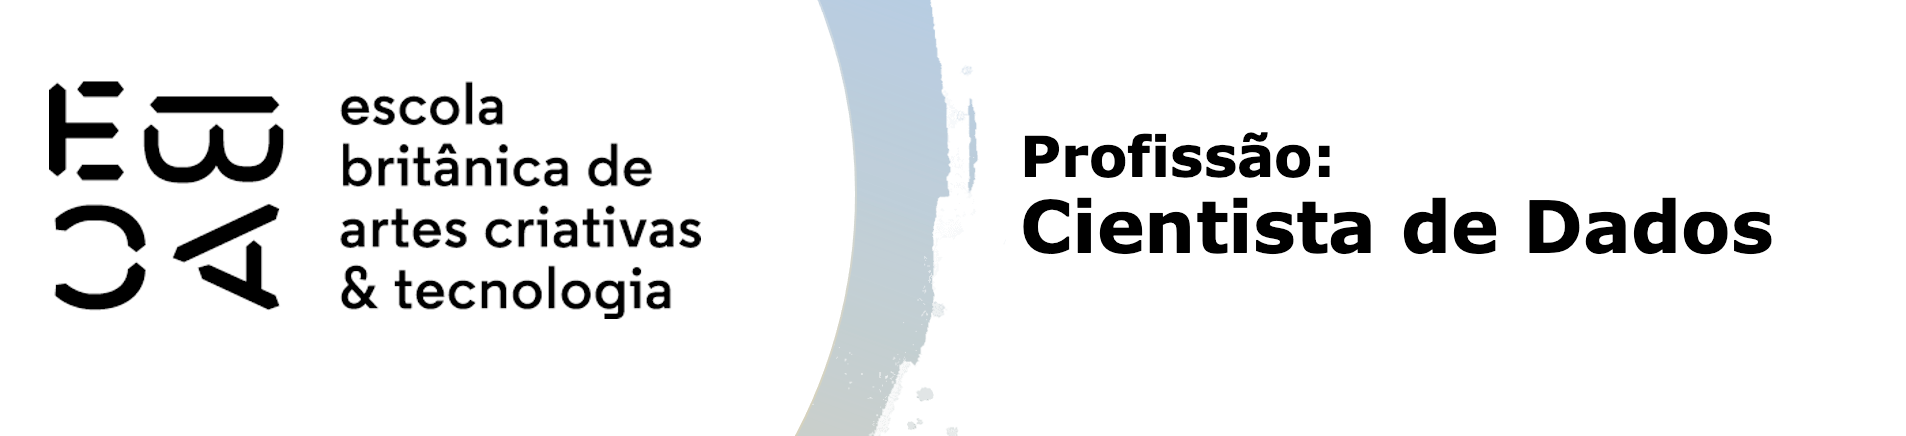

# Tarefa - Agrupamento hierárquico

Neste exercício vamos usar a base [online shoppers purchase intention](https://archive.ics.uci.edu/ml/datasets/Online+Shoppers+Purchasing+Intention+Dataset) de Sakar, C.O., Polat, S.O., Katircioglu, M. et al. Neural Comput & Applic (2018). [Web Link](https://doi.org/10.1007/s00521-018-3523-0).

A base trata de registros de 12.330 sessões de acesso a páginas, cada sessão sendo de um único usuário em um período de 12 meses, para posteriormente estudarmos a relação entre o design da página e o perfil do cliente - "Será que clientes com comportamento de navegação diferentes possuem propensão a compra diferente?" 

Nosso objetivo agora é agrupar as sessões de acesso ao portal considerando o comportamento de acesso e informações da data, como a proximidade a uma data especial, fim de semana e o mês.

|Variavel                |Descrição          | 
|------------------------|:-------------------| 
|Administrative          | Quantidade de acessos em páginas administrativas| 
|Administrative_Duration | Tempo de acesso em páginas administrativas | 
|Informational           | Quantidade de acessos em páginas informativas  | 
|Informational_Duration  | Tempo de acesso em páginas informativas  | 
|ProductRelated          | Quantidade de acessos em páginas de produtos | 
|ProductRelated_Duration | Tempo de acesso em páginas de produtos | 
|BounceRates             | *Percentual de visitantes que entram no site e saem sem acionar outros *requests* durante a sessão  | 
|ExitRates               | * Soma de vezes que a página é visualizada por último em uma sessão dividido pelo total de visualizações | 
|PageValues              | * Representa o valor médio de uma página da Web que um usuário visitou antes de concluir uma transação de comércio eletrônico | 
|SpecialDay              | Indica a proximidade a uma data festiva (dia das mães etc) | 
|Month                   | Mês  | 
|OperatingSystems        | Sistema operacional do visitante | 
|Browser                 | Browser do visitante | 
|Region                  | Região | 
|TrafficType             | Tipo de tráfego                  | 
|VisitorType             | Tipo de visitante: novo ou recorrente | 
|Weekend                 | Indica final de semana | 
|Revenue                 | Indica se houve compra ou não |

\* variávels calculadas pelo google analytics

In [73]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from sklearn.preprocessing import Normalizer

from gower import gower_matrix
from scipy.spatial           import distance
from scipy.spatial.distance  import pdist, squareform
from scipy.cluster           import hierarchy as shc
from scipy.cluster.hierarchy import linkage, fcluster, dendrogram

sns.set_theme()

In [7]:
df_raw = pd.read_csv('data/online_shoppers_intention.csv')

In [8]:
df_raw.head()

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,Month,OperatingSystems,Browser,Region,TrafficType,VisitorType,Weekend,Revenue
0,0,0.0,0,0.0,1,0.000000,0.20,0.20,0.0,0.0,Feb,1,1,1,1,Returning_Visitor,False,False
1,0,0.0,0,0.0,2,64.000000,0.00,0.10,0.0,0.0,Feb,2,2,1,2,Returning_Visitor,False,False
2,0,0.0,0,0.0,1,0.000000,0.20,0.20,0.0,0.0,Feb,4,1,9,3,Returning_Visitor,False,False
3,0,0.0,0,0.0,2,2.666667,0.05,0.14,0.0,0.0,Feb,3,2,2,4,Returning_Visitor,False,False
4,0,0.0,0,0.0,10,627.500000,0.02,0.05,0.0,0.0,Feb,3,3,1,4,Returning_Visitor,True,False


In [61]:
selected_columns_num = ['Administrative', 'Administrative_Duration', 'Informational', 
                        'Informational_Duration', 'ProductRelated', 'ProductRelated_Duration', 'SpecialDay']

selected_columns_cat = ['Month', 'Weekend']

selected_columns = selected_columns_num + selected_columns_cat

df0 = df_raw[selected_columns].copy()

## Análise descritiva

Faça uma análise descritiva das variáveis do escopo.

- Verifique a distribuição dessas variáveis

In [62]:
df0[selected_columns_num].describe().T

,count,mean,std,min,25%,50%,75%,max
Administrative,12330.0,2.315166,3.321784,0.0,0.0000,1.000000,4.000000,27.00000
Administrative_Duration,12330.0,80.818611,176.779107,0.0,0.0000,7.500000,93.256250,3398.75000
Informational,12330.0,0.503569,1.270156,0.0,0.0000,0.000000,0.000000,24.00000
Informational_Duration,12330.0,34.472398,140.749294,0.0,0.0000,0.000000,0.000000,2549.37500
ProductRelated,12330.0,31.731468,44.475503,0.0,7.0000,18.000000,38.000000,705.00000
ProductRelated_Duration,12330.0,1194.746220,1913.669288,0.0,184.1375,598.936905,1464.157214,63973.52223
SpecialDay,12330.0,0.061427,0.198917,0.0,0.0000,0.000000,0.000000,1.00000


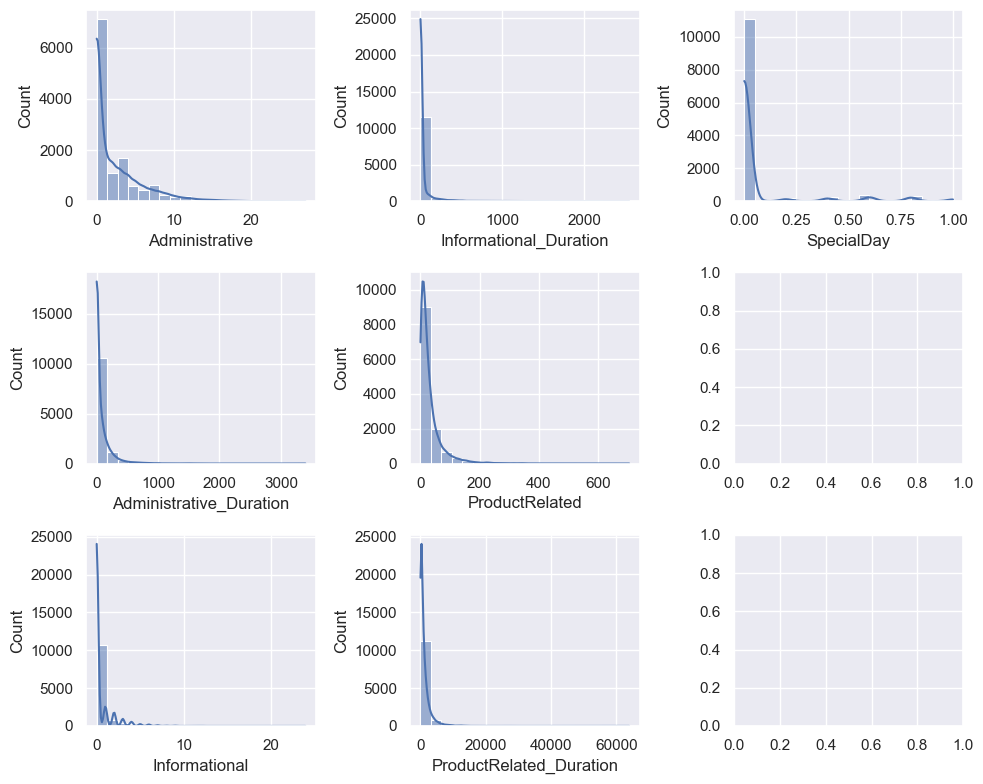

In [63]:
fig, ax = plt.subplots(nrows=3, ncols=3, figsize=(10,8))

for i in range(7):
    sns.histplot(data = df0, x=selected_columns_num[i], bins=20, kde=True, ax=ax[i%3,i//3])
    plt.tight_layout()

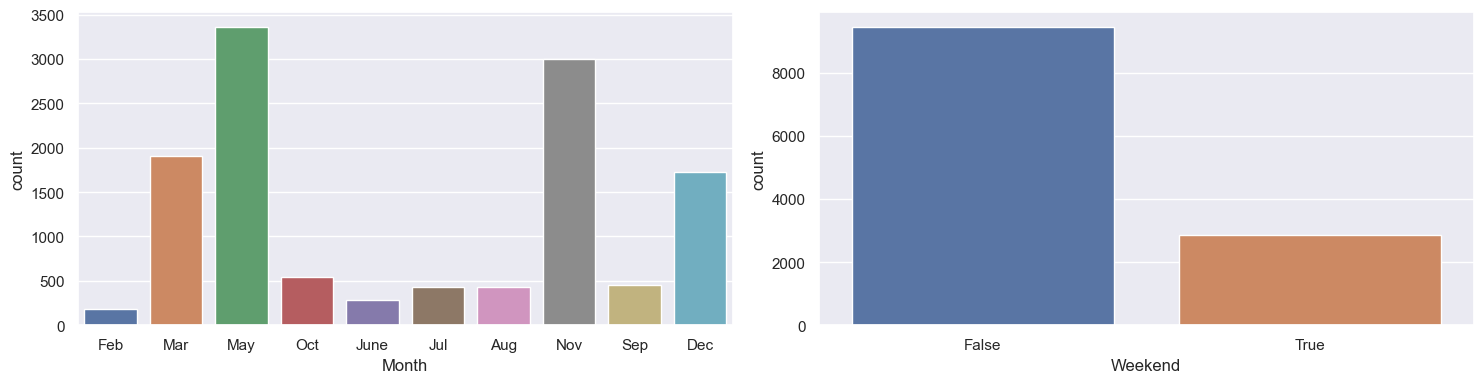

In [65]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15,4))

for i in range(2):
    sns.countplot(x = df0[selected_columns_cat[i]], ax=ax[i])
    plt.tight_layout()

- Veja se há valores *missing* e caso haja, decida o que fazer

In [66]:
df0.isna().sum()

Administrative             0
Administrative_Duration    0
Informational              0
Informational_Duration     0
ProductRelated             0
ProductRelated_Duration    0
SpecialDay                 0
Month                      0
Weekend                    0
dtype: int64

- Faça mais algum tratamento nas variáveis caso ache pertinente

## Variáveis de agrupamento

Liste as variáveis que você vai querer utilizar. Essa é uma atividade importante do projeto, e tipicamente não a recebemos pronta. Não há resposta pronta ou correta, mas apenas critérios e a sua decisão. Os critérios são os seguintes:

- Selecione para o agrupamento variáveis que descrevam o padrão de navegação na sessão.
- Selecione variáveis que indiquem a característica da data.
- Não se esqueça de que você vai precisar realizar um tratamento especial para variáveis qualitativas.
- Trate adequadamente valores faltantes.

In [67]:
df0_cat_norm = pd.DataFrame(Normalizer().fit_transform(df0[selected_columns_num]), columns = selected_columns_num)
df0_cat_norm.describe().T

,count,mean,std,min,25%,50%,75%,max
Administrative,12330.0,0.005030,0.031012,0.0,0.000000,0.000551,0.003781,1.000000
Administrative_Duration,12330.0,0.101122,0.196409,0.0,0.000000,0.006248,0.099780,0.999984
Informational,12330.0,0.001016,0.018831,0.0,0.000000,0.000000,0.000000,1.000000
Informational_Duration,12330.0,0.025292,0.098827,0.0,0.000000,0.000000,0.000000,0.999634
ProductRelated,12330.0,0.094722,0.223709,0.0,0.021124,0.032799,0.052652,1.000000
ProductRelated_Duration,12330.0,0.901435,0.257325,0.0,0.977277,0.997496,0.999412,1.000000
SpecialDay,12330.0,0.002827,0.033885,0.0,0.000000,0.000000,0.000000,0.707107


In [68]:
df0_num_dummie = pd.get_dummies(df0[selected_columns_cat])
df0_num_dummie.head()

,Weekend,Month_Aug,Month_Dec,Month_Feb,Month_Jul,Month_June,Month_Mar,Month_May,Month_Nov,Month_Oct,Month_Sep
0,False,0,0,1,0,0,0,0,0,0,0
1,False,0,0,1,0,0,0,0,0,0,0
2,False,0,0,1,0,0,0,0,0,0,0
3,False,0,0,1,0,0,0,0,0,0,0
4,True,0,0,1,0,0,0,0,0,0,0


In [69]:
df1 = pd.concat([df0_cat_norm, df0_num_dummie], axis=1)
df1.head()

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,SpecialDay,Weekend,Month_Aug,Month_Dec,Month_Feb,Month_Jul,Month_June,Month_Mar,Month_May,Month_Nov,Month_Oct,Month_Sep
0,0.0,0.0,0.0,0.0,1.000000,0.000000,0.0,False,0,0,1,0,0,0,0,0,0,0
1,0.0,0.0,0.0,0.0,0.031235,0.999512,0.0,False,0,0,1,0,0,0,0,0,0,0
2,0.0,0.0,0.0,0.0,1.000000,0.000000,0.0,False,0,0,1,0,0,0,0,0,0,0
3,0.0,0.0,0.0,0.0,0.600000,0.800000,0.0,False,0,0,1,0,0,0,0,0,0,0
4,0.0,0.0,0.0,0.0,0.015934,0.999873,0.0,True,0,0,1,0,0,0,0,0,0,0


## Número de grupos

Nesta atividade vamos adotar uma abordagem bem pragmática e avaliar agrupamentos hierárquicos com 3 e 4 grupos, por estarem bem alinhados com uma expectativa e estratégia do diretor da empresa. 

*Atenção*: Cuidado se quiser fazer o dendrograma, pois com muitas observações ele pode ser mais complicado de fazer, e dependendo de como for o comando, ele pode travar o *kernell* do seu python.

In [71]:
columns_cat = [True if x in df0_num_dummie.columns else False for x in df1.columns]

In [72]:
columns_cat

[False,
 False,
 False,
 False,
 False,
 False,
 False,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True]

In [74]:
distancia_gower = gower_matrix(df1, cat_features=columns_cat)

In [75]:
distancia_gower[:5, :5]

array([[0.        , 0.10934876, 0.        , 0.06666668, 0.16577439],
       [0.10934876, 0.        , 0.10934876, 0.04268208, 0.05642564],
       [0.        , 0.10934876, 0.        , 0.06666668, 0.16577439],
       [0.06666668, 0.04268208, 0.06666668, 0.        , 0.09910771],
       [0.16577439, 0.05642564, 0.16577439, 0.09910771, 0.        ]],
      dtype=float32)

In [76]:
gdv = squareform(distancia_gower, force='tovector')

In [77]:
gdv.shape

(76008285,)

In [78]:
Z = linkage(gdv, method='complete')

In [80]:
df1['n3'] = fcluster(Z, 3, criterion='maxclust')
df1.n3.value_counts()

1    8552
2    3364
3     414
Name: n3, dtype: int64

In [81]:
df1['n4'] = fcluster(Z, 4, criterion='maxclust')
df1.n4.value_counts()

2    4679
1    3873
3    3364
4     414
Name: n4, dtype: int64

## Avaliação dos grupos

Construa os agrupamentos com a técnica adequada que vimos em aula. Não se esqueça de tratar variáveis qualitativas, padronizar escalas das quantitativas, tratar valores faltantes e utilizar a distância correta.

Faça uma análise descritiva para pelo menos duas soluções de agrupamentos (duas quantidades diferentes de grupos) sugeridas no item anterior, utilizando as variáveis que estão no escopo do agrupamento.
- Com base nesta análise e nas análises anteriores, decida pelo agrupamento final. 
- Se puder, sugira nomes para os grupos.

In [98]:
df_columns = (list(df1.columns.values))
df_columns

['Administrative',
 'Administrative_Duration',
 'Informational',
 'Informational_Duration',
 'ProductRelated',
 'ProductRelated_Duration',
 'SpecialDay',
 'Weekend',
 'Month_Aug',
 'Month_Dec',
 'Month_Feb',
 'Month_Jul',
 'Month_June',
 'Month_Mar',
 'Month_May',
 'Month_Nov',
 'Month_Oct',
 'Month_Sep',
 'n3',
 'n4']

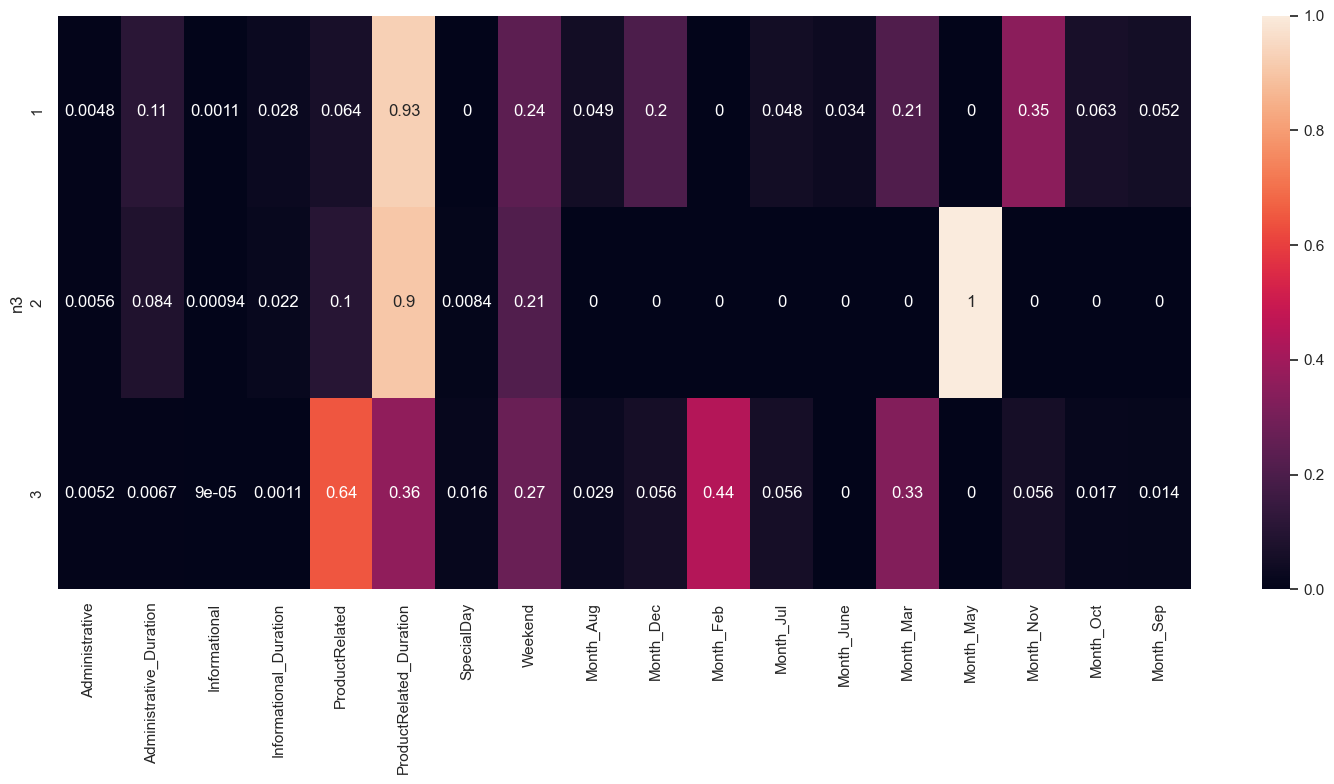

In [100]:
df_columns = list(df1.columns.values)
df_columns.remove('n4')
df_heat = df1[df_columns].groupby('n3').mean()

plt.figure(figsize=(15,8))
sns.heatmap(df_heat, annot=True)
plt.tight_layout()

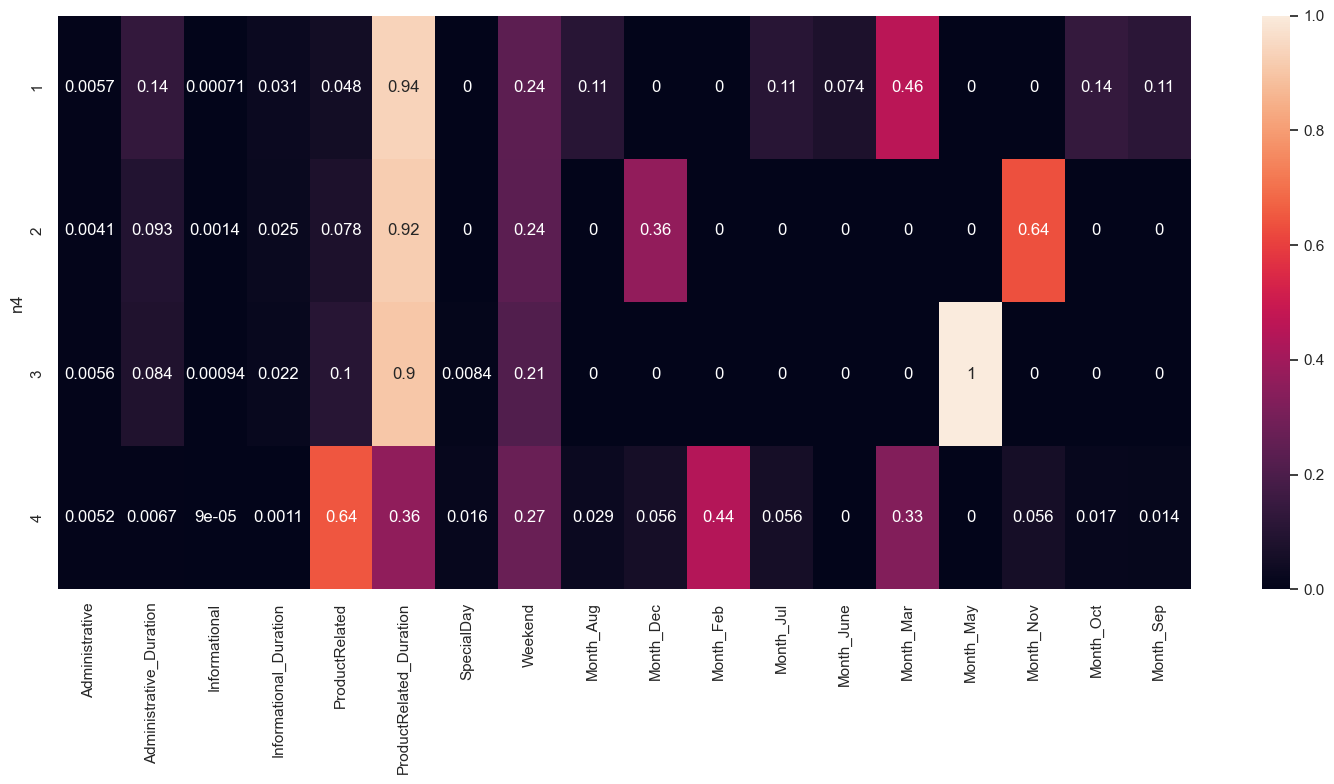

In [101]:
df_columns = list(df1.columns.values)
df_columns.remove('n3')
df_heat = df1[df_columns].groupby('n4').mean()

plt.figure(figsize=(15,8))
sns.heatmap(df_heat, annot=True)
plt.tight_layout()

## Avaliação de resultados

Avalie os grupos obtidos com relação às variáveis fora do escopo da análise (minimamente *bounce rate* e *revenue*). 
- Qual grupo possui clientes mais propensos à compra?

In [102]:
df2 = pd.concat([df, df1['n4']], axis=1)
df2.head()

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,Month,OperatingSystems,Browser,Region,TrafficType,VisitorType,Weekend,Revenue,n4
0,0,0.0,0,0.0,1,0.000000,0.20,0.20,0.0,0.0,Feb,1,1,1,1,Returning_Visitor,False,False,4
1,0,0.0,0,0.0,2,64.000000,0.00,0.10,0.0,0.0,Feb,2,2,1,2,Returning_Visitor,False,False,4
2,0,0.0,0,0.0,1,0.000000,0.20,0.20,0.0,0.0,Feb,4,1,9,3,Returning_Visitor,False,False,4
3,0,0.0,0,0.0,2,2.666667,0.05,0.14,0.0,0.0,Feb,3,2,2,4,Returning_Visitor,False,False,4
4,0,0.0,0,0.0,10,627.500000,0.02,0.05,0.0,0.0,Feb,3,3,1,4,Returning_Visitor,True,False,4


In [103]:
df2[['BounceRates','Revenue', 'n4']].groupby('n4').mean()

,BounceRates,Revenue
n4,,
1,0.011968,0.145365
2,0.017811,0.208592
3,0.026867,0.108502
4,0.129352,0.009662


<div style="background: #EEEEF4; padding: 15px 20px; border-radius: 5px; margin-top: 20px">
    <p style="font-size: 11px; color: #666; font-weight: bold">Resposta</p>
    <p>O Grupo 2 é o que mais compra, sempre no mês de Novembro e Dezembro. O grupo 3 são aqueles que compra sempre em Maio. O grupo 4 é aquele que menos compra apesar de serem os que mais acessam a página de produto, porém ficam pouco tempo nela</p>
</div>